In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os
sns.set(context="paper", style="white")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Mount to google drive (The same as part 1)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**4. UMAP scatter plot**

In [ ]:
def scatter_plot(embedding, 
                 df, 
                 ax, 
                 color_by='experiment', 
                 title='', 
                 custom_font={'fontname':'Arial', 'size':'14', 'weight':'bold'},
                 reversed=True):
  '''To plot UMAP 
  Args:
  ----
  Input:
  embedding: 2D UMAP latent space
  df: a dataframe to specify for "color_by"
  ax: Matplotlib axis object
  color_by: name of the column of df to make color
  title: a title of the figure
  custom font: a dictionary to customized font
  reversed: if False, display color_by in ascending order else descending
  Output:
  A scatter plot of UMAP
  '''
  colors = sorted(list(df[color_by].unique()), reverse=reversed)
  for i in range(len(colors)):
    mask = df[color_by] == colors[i]
    img = ax.scatter(embedding[mask, 0], embedding[mask, 1], label=colors[i], s=10, alpha=1)
  # End of for
  ax.legend(bbox_to_anchor=(1.00, 1), loc='upper left', markerscale=3, prop={'size':12})
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.set_xlabel('UMAP dimension 1', **custom_font)
  ax.set_ylabel('UMAP dimension 2', **custom_font)
  ax.set_title(title, custom_font)
  ax.grid()
  return None 

def scatter_plot_with_colorbar(
    embedding, 
    df, 
    fig, 
    ax, 
    color_by='experiment',  
    title='', 
    custom_font={'fontname':'Arial', 'size':'14', 'weight':'bold'},
    cm = plt.cm.get_cmap('viridis')):
  '''To plot UMAP with colobar
    Args:
    ----
    Input:
    embedding: 2D UMAP latent space
    df: a dataframe to specify for "color_by"
    ax: Matplotlib axis object
    color_by: name of the column of df to make color
    title: a title of the figure
    custom font: a dictionary to customized font
    cm: a color map
    Output:
    A scatter plot of UMAP

    Note: (for simplicity) make a separate function instead of combination with 
    the scatter_plot() function above
  '''
  c = df[color_by]
  img = ax.scatter(embedding[:, 0], embedding[:, 1], c=c, cmap=cm)
  fig.colorbar(img, ax=ax, orientation="vertical")
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.set_xlabel('UMAP dimension 1', **custom_font)
  ax.set_ylabel('UMAP dimension 2', **custom_font)
  ax.set_title(title, custom_font)
  ax.grid()
  return None

#**5. Combination of embeddings_pca and metadata datasets**

**Loading latent features of embedddings:  embeddings_pca.npz file**

In [ ]:
principal_components = np.load(os.path.join(path, 'embeddings_pca.npz'))['arr_0']
n_components = principal_components.shape[1]
print(f'principal_components.shape = {principal_components.shape}')
print(f'n_components = {n_components}')

principal_components.shape = (305520, 50)
n_components = 50


In [ ]:
# Making index and column names for PCA data
df_embeddings_pca=pd.DataFrame(data=principal_components[0:, 0:],
                               index=[i for i in range(principal_components.shape[0])],
                               columns=['feature_' + str(i) for i in range(n_components)])
df_embeddings_pca.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0.132417,0.319708,0.316053,0.391044,0.393467,0.590292,0.191758,0.351341,0.461592,0.466987,0.536253,0.437953,0.572890,0.391879,0.349071,0.445347,0.341853,0.504132,0.604076,0.399608,0.427333,0.464913,0.465775,0.489638,0.494150,0.408199,0.506514,0.453068,0.485315,0.495060,0.524268,0.509307,0.401345,0.385564,0.446745,0.509490,0.489981,0.483025,0.421543,0.459811,0.460953,0.469725,0.364876,0.469103,0.387249,0.432969,0.405848,0.421003,0.464734,0.396111
1,0.061210,0.292411,0.343654,0.439015,0.361604,0.531461,0.252884,0.412200,0.441596,0.501719,0.495689,0.523878,0.535313,0.316499,0.323712,0.450942,0.355204,0.422611,0.508067,0.463248,0.329442,0.415452,0.519158,0.433616,0.505124,0.399090,0.473961,0.459280,0.443921,0.536239,0.592748,0.438370,0.304310,0.428634,0.419176,0.412721,0.586779,0.458541,0.426260,0.493364,0.392178,0.475611,0.356532,0.441358,0.348609,0.459533,0.429846,0.399099,0.477208,0.351983
2,0.108674,0.336356,0.406311,0.407748,0.389359,0.544734,0.170589,0.417111,0.398482,0.501507,0.543979,0.426225,0.562843,0.373681,0.286814,0.442930,0.384244,0.447445,0.487309,0.343914,0.411652,0.455360,0.475752,0.472525,0.568680,0.421540,0.461507,0.463201,0.488834,0.551272,0.477849,0.458477,0.422462,0.409628,0.461943,0.480689,0.528402,0.403698,0.393848,0.518154,0.433064,0.488549,0.350806,0.464925,0.416482,0.472803,0.411860,0.395524,0.441884,0.316029
3,0.134047,0.331165,0.352454,0.374873,0.386793,0.548409,0.301229,0.333972,0.481181,0.398064,0.521756,0.534212,0.646041,0.257011,0.379889,0.466514,0.358237,0.477292,0.448120,0.455474,0.459841,0.412216,0.453976,0.428564,0.478375,0.412939,0.589747,0.457108,0.443763,0.552876,0.580033,0.431542,0.369624,0.404297,0.409220,0.426541,0.424165,0.544120,0.376512,0.540485,0.427619,0.513559,0.290861,0.496288,0.453448,0.510672,0.393186,0.383477,0.426390,0.304706
4,0.158918,0.298984,0.295349,0.507113,0.479140,0.370933,0.245185,0.457743,0.357245,0.557310,0.463709,0.405359,0.481736,0.348999,0.473843,0.465302,0.301833,0.443796,0.521400,0.393267,0.351158,0.427668,0.416272,0.483449,0.573538,0.381656,0.468539,0.447308,0.400820,0.486963,0.550362,0.485900,0.404162,0.402286,0.467217,0.432694,0.446292,0.539093,0.410782,0.351357,0.461101,0.562216,0.352639,0.410931,0.359736,0.456468,0.449346,0.318593,0.505775,0.429760


**Load metadata.csv**

In [ ]:
df_metadata = pd.read_csv(os.path.join(path, 'metadata.csv'))
df_metadata.shape

(305520, 11)

**Combine embeddings_pca and metadata**

In [ ]:
%%time
df = pd.merge(df_metadata, 
              df_embeddings_pca, 
              left_index=True, 
              right_index=True, 
              how='inner')

CPU times: user 123 ms, sys: 14.9 ms, total: 138 ms
Wall time: 137 ms


In [ ]:
df.head(5)

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,HRCE-1_1_AA02_1,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,1,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...,0.132417,0.319708,0.316053,0.391044,0.393467,0.590292,0.191758,0.351341,0.461592,0.466987,0.536253,0.437953,0.572890,0.391879,0.349071,0.445347,0.341853,0.504132,0.604076,0.399608,0.427333,0.464913,0.465775,0.489638,0.494150,0.408199,0.506514,0.453068,0.485315,0.495060,0.524268,0.509307,0.401345,0.385564,0.446745,0.509490,0.489981,0.483025,0.421543,0.459811,0.460953,0.469725,0.364876,0.469103,0.387249,0.432969,0.405848,0.421003,0.464734,0.396111
1,HRCE-1_1_AA02_2,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,2,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...,0.061210,0.292411,0.343654,0.439015,0.361604,0.531461,0.252884,0.412200,0.441596,0.501719,0.495689,0.523878,0.535313,0.316499,0.323712,0.450942,0.355204,0.422611,0.508067,0.463248,0.329442,0.415452,0.519158,0.433616,0.505124,0.399090,0.473961,0.459280,0.443921,0.536239,0.592748,0.438370,0.304310,0.428634,0.419176,0.412721,0.586779,0.458541,0.426260,0.493364,0.392178,0.475611,0.356532,0.441358,0.348609,0.459533,0.429846,0.399099,0.477208,0.351983
2,HRCE-1_1_AA02_3,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,3,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...,0.108674,0.336356,0.406311,0.407748,0.389359,0.544734,0.170589,0.417111,0.398482,0.501507,0.543979,0.426225,0.562843,0.373681,0.286814,0.442930,0.384244,0.447445,0.487309,0.343914,0.411652,0.455360,0.475752,0.472525,0.568680,0.421540,0.461507,0.463201,0.488834,0.551272,0.477849,0.458477,0.422462,0.409628,0.461943,0.480689,0.528402,0.403698,0.393848,0.518154,0.433064,0.488549,0.350806,0.464925,0.416482,0.472803,0.411860,0.395524,0.441884,0.316029
3,HRCE-1_1_AA02_4,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,4,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...,0.134047,0.331165,0.352454,0.374873,0.386793,0.548409,0.301229,0.333972,0.481181,0.398064,0.521756,0.534212,0.646041,0.257011,0.379889,0.466514,0.358237,0.477292,0.448120,0.455474,0.459841,0.412216,0.453976,0.428564,0.478375,0.412939,0.589747,0.457108,0.443763,0.552876,0.580033,0.431542,0.369624,0.404297,0.409220,0.426541,0.424165,0.544120,0.376512,0.540485,0.427619,0.513559,0.290861,0.496288,0.453448,0.510672,0.393186,0.383477,0.426390,0.304706
4,HRCE-1_1_AA03_1,HRCE-1_1_AA03,HRCE,HRCE-1,1,AA03,1,Active SARS-CoV-2,acetylcysteine,1.0,"CC(=O)N[C@H](CS)C(O)=O |a:4,r|",0.158918,0.298984,0.295349,0.507113,0.479140,0.370933,0.245185,0.457743,0.357245,0.557310,0.463709,0.405359,0.481736,0.348999,0.473843,0.465302,0.301833,0.443796,0.521400,0.393267,0.351158,0.427668,0.416272,0.483449,0.573538,0.381656,0.468539,0.447308,0.400820,0.486963,0.550362,0.485900,0.404162,0.402286,0.467217,0.432694,0.446292,0.539093,0.410782,0.351357,0.461101,0.562216,0.352639,0.410931,0.359736,0.456468,0.449346,0.318593,0.505775,0.429760


In [ ]:
# Save this data for Part 4.
df.to_csv(os.path.join(path, 'df_embeddings_pca.csv'), index=Falsehand)

#**6. Investigate Disease conditions (absent any treatment) using UMAP**

**Get "un-treatment" data frame**

In [ ]:
df_untreatment = df[pd.isnull(df['treatment'])]  
print(df_untreatment.shape)
df_untreatment = df_untreatment[df_untreatment['disease_condition'].notnull()]
print(df_untreatment.shape)

(42336, 61)
(35432, 61)


**Call umap instance**

In [ ]:
reducer = umap.UMAP(random_state=42)
reducer

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

**UMAP transform: Take a lot of memory and time**  
It is the main reason to use PCA with 50 compoments instead of all 1024 features as in the raw data.  
NOTE: We also can use t-SNE but UMAP seems to be better in technical localized clustering aspects as well as faster and less memory.

In [ ]:
%%time
# Get column names: feature_0 to feature_50 of embeddings_PCA
cols = ['feature_' + str(i) for i in range(n_components)]

# fit_tranform
embedding = reducer.fit_transform(df_untreatment[cols])

CPU times: user 1min 1s, sys: 3.98 s, total: 1min 5s
Wall time: 59.7 s


In [ ]:
embedding.shape

(35432, 2)

**Plot UMAP**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


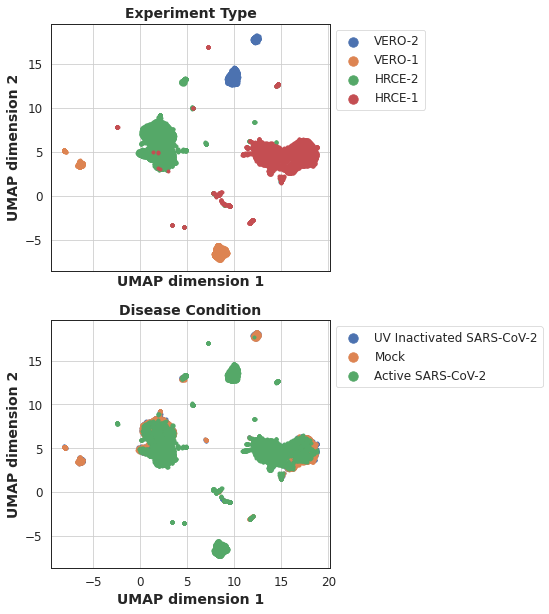

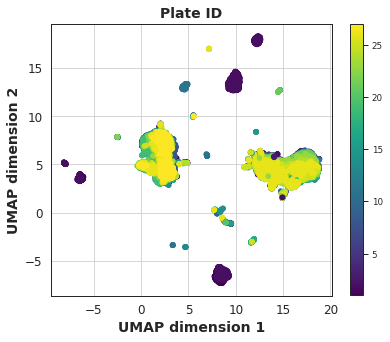

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(5, 10))
scatter_plot(embedding, df_untreatment, ax1, color_by='experiment', title='Experiment Type')
scatter_plot(embedding, df_untreatment, ax2, color_by='disease_condition', title='Disease Condition')
fig, ax3 = plt.subplots(figsize=(6.3, 5))                               
scatter_plot_with_colorbar(embedding, df_untreatment, fig, ax3, color_by='plate', title='Plate ID')
plt.show()

**As can be seen in the above figures, the data is largely seperated by the experiment type. As a result, disease conditions (absent any treatment) are also followed these patterns.**

**Note: With a better hardware than google colab, I have run UMAP with all 1024 features and all disease conditions and the results also indicate that data is large seperated by experiment type**

**End of Part 2**